# Importação das bibliotecas necessárias
As bibliotecas necessárias são importadas para manipulação de tensores (torch), carregamento de dados (DataLoader), visualizações (matplotlib), normalização de memória (psutil) e barra de progresso (tqdm).

In [1]:
#0 Importação das bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import psutil  # Certificar que a biblioteca psutil é importadaot as plt
from tqdm import tqdm

## Configuração do dispositivo para GPU ou CPU
- O dispositivo a ser usado (GPU ou CPU) é identificado e configurado.
- Além disso, são mostradas informações detalhadas sobre as GPUs detectadas e a memória total disponível no sistema.

In [2]:
#1 Configuração do dispositivo para GPU ou CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

if device.type == "cuda":
    gpu_count = torch.cuda.device_count()
    print(f"Número de GPUs detectadas: {gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / (1024 ** 3)
        print(f"GPU {i + 1}: {gpu_name} com {gpu_memory:.2f} GB de memória")

ram_memory = psutil.virtual_memory().total / (1024 ** 3)
print(f"Memória total do sistema (RAM): {ram_memory:.2f} GB")


Usando o dispositivo: cuda
Número de GPUs detectadas: 2
GPU 1: NVIDIA GeForce RTX 2080 Ti com 10.75 GB de memória
GPU 2: NVIDIA GeForce RTX 2080 Ti com 10.75 GB de memória
Memória total do sistema (RAM): 31.29 GB


# Carregamento do Dataset real
- O dataset de imagens 3D de ressonância magnética do joelho é carregado dos arquivos fornecidos.
- Os dados normais e anormais são concatenados, e rótulos correspondentes são atribuídos para treinamento e validação.

In [3]:
#2 Dataset real a partir dos arquivos fornecidos
class KneeMRIDataset(Dataset):
    def __init__(self, normal_path, abnormal_path):
        self.normal_data = np.load(normal_path)
        self.abnormal_data = np.load(abnormal_path)
        
        # Criar rótulos: 0 para normal, 1 para anormal
        self.data = np.concatenate((self.normal_data, self.abnormal_data), axis=0)
        self.labels = np.concatenate((
            np.zeros(len(self.normal_data)),  # Rótulo 0 para normal
            np.ones(len(self.abnormal_data))  # Rótulo 1 para anormal
        ))

        # Normalizar as imagens entre 0 e 1
        self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        volume = self.data[idx]
        label = self.labels[idx]
        volume = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)  # Adiciona canal
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0).unsqueeze(1).repeat(1, *volume.shape[1:])  # Ajusta label para [1, depth, height, width]
        return volume, label

# Divisão do dataset em treino e validação
# Os dados carregados são divididos em conjuntos de treino e validação com proporção 70%-30%.
normal_path = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/normal-3DESS-128-64.npy"
abnormal_path = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/abnormal-3DESS-128-64.npy"

dataset = KneeMRIDataset(normal_path, abnormal_path)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Tamanho do dataset de treinamento: {len(train_dataset)}")
print(f"Tamanho do dataset de validação: {len(val_dataset)}")


Tamanho do dataset de treinamento: 2083
Tamanho do dataset de validação: 893


# Definição do modelo Simplified-UNet
- O modelo Simplified-UNet é uma versão simplificada de uma rede U-Net, usada para segmentação de imagens 3D.
- Ele inclui codificadores, decodificadores e camadas de pooling e upsampling.

In [4]:
#3 Definição do modelo Simplified-UNet
class SimplifiedUNet(nn.Module):
    def __init__(self):
        super(SimplifiedUNet, self).__init__()
        self.encoder1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.decoder1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = nn.ConvTranspose3d(64, 1, kernel_size=2, stride=2)

    def forward(self, x):
        x1 = torch.relu(self.encoder1(x))
        p1 = self.pool1(x1)
        x2 = torch.relu(self.encoder2(p1))
        p2 = self.pool2(x2)
        d1 = torch.relu(self.decoder1(p2))
        d2 = self.decoder2(d1)  # Sem sigmoide, pois usamos BCEWithLogitsLoss
        return d2

model = SimplifiedUNet().to(device)
print(model)


SimplifiedUNet(
  (encoder1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder1): ConvTranspose3d(128, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (decoder2): ConvTranspose3d(64, 1, kernel_size=(2, 2, 2), stride=(2, 2, 2))
)


# Função de treinamento com precisão mista
- A função treina o modelo usando o conjunto de dados de treinamento, calcula a perda e avalia no conjunto de validação.
- Inclui otimização de memória com torch.autocast e GradScaler para precisão mista.

In [5]:
#4 Função de treinamento ajustada para correção de memória e precisão mista
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    scaler = torch.amp.GradScaler()  # Configuração correta do GradScaler

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        print(f"Epoch {epoch + 1}/{epochs}")
        for inputs, labels in tqdm(train_loader, desc="Treinando", leave=False):
            torch.cuda.empty_cache()  # Liberar memória antes de cada batch

            inputs = inputs.to(device)  # Inputs já têm o canal adicionado no dataset
            labels = labels.to(device)  # Labels ajustadas para corresponder ao tamanho da saída

            optimizer.zero_grad()

            # Treinamento com precisão mista
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validando", leave=False):
                torch.cuda.empty_cache()  # Liberar memória antes de cada batch

                inputs = inputs.to(device)
                labels = labels.to(device)

                # Validação com precisão mista
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

        print(f"Train Loss: {train_loss / len(train_loader.dataset):.4f}, Val Loss: {val_loss / len(val_loader.dataset):.4f}")


# Configuração do otimizador e função de perda
O otimizador Adam é configurado para ajustar os parâmetros do modelo com base na perda calculada.

In [6]:
#5 Configuração do otimizador e função de perda
criterion = nn.BCEWithLogitsLoss()  # Função de perda ajustada
model = SimplifiedUNet().to(device)  # Certificar que o modelo está definido
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Início do treinamento do modelo
O treinamento é iniciado com os dados de treino e validação por 5 épocas.

In [7]:
#6 Treinar o modelo
torch.cuda.empty_cache()  # Garantir memória limpa antes do treinamento
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch 1/5


Train Loss: 0.6902, Val Loss: 0.6795
Epoch 2/5


Train Loss: 0.6896, Val Loss: 0.6814
Epoch 3/5


Train Loss: 0.6897, Val Loss: 0.6825
Epoch 4/5


Train Loss: 0.6894, Val Loss: 0.6820
Epoch 5/5


Train Loss: 0.6893, Val Loss: 0.6800


# Salvando e Visualizando os resultados
Após o treinamento, o modelo é avaliado em uma amostra do conjunto de validação, e os resultados são exibidos.

In [8]:
#8 Salvando o modelo treinado
import os
import torch
from datetime import datetime

save_dir = "/home/thalles.fontainha/modelos"  # Diretório para salvar os modelos
os.makedirs(save_dir, exist_ok=True)  # Garante que o diretório exista

# Nome do arquivo baseado na data e hora
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"Simplified_UNet_treinado_{current_time}.pth"

# Caminho completo para salvar o modelo
save_path = os.path.join(save_dir, model_filename)

# Salvar o modelo
torch.save(model.state_dict(), save_path)
print(f"Modelo salvo com sucesso em: {save_path}")


Modelo salvo com sucesso em: /home/thalles.fontainha/modelos/Simplified_UNet_treinado_2025-01-23_15-25-52.pth


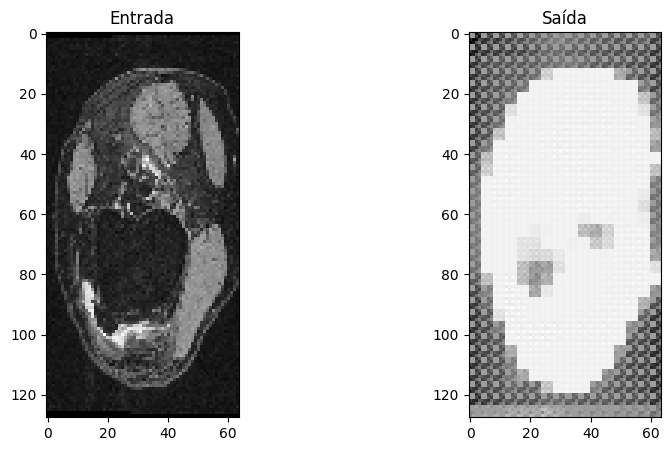

Visualização concluída com sucesso!


In [15]:
#9 Visualização dos resultados
# Após o treinamento, o modelo é avaliado em uma amostra do conjunto de validação, e os resultados são exibidos.
model.eval()
sample_input, sample_label = val_dataset[0]
sample_input = sample_input.unsqueeze(0).to(device)  # Adicionar dimensão do batch
sample_output = model(sample_input).cpu().detach().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Entrada")
plt.imshow(sample_input.cpu().squeeze()[32, :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Saída")
plt.imshow(sample_output.squeeze()[32, :, :], cmap="gray")
plt.show()

### Interpretação do resultado visualizado
# - A imagem de entrada mostra a fatia de ressonância magnética original.
# - A imagem de saída representa a segmentação gerada pelo modelo, destacando áreas relevantes.
# - Para validação quantitativa, métricas como Dice Coefficient e IoU podem ser usadas.
# - Passos adicionais podem incluir refinamento do modelo, ajuste de hiperparâmetros ou aumento do conjunto de dados para melhorar a precisão da segmentação.

print("Visualização concluída com sucesso!")


### Resultado da Segmentação

- **Imagem à esquerda (Entrada):**
  - Corresponde à fatia original da ressonância magnética utilizada como entrada para o modelo.
  - Mostra detalhes anatômico.

- **Imagem à direita (Saída):**
  - Representa a saída gerada pelo modelo Simplified-UNet.
  - Áreas brancas indicam regiões segmentadas como relevantes, com foco em certas partes específicas da imagem.
  - Observa-se que há regiões bem definidas (manchas brancas), mas também áreas de ruído ou segmentação incompleta.

- **Interpretação:**
  - A segmentação sugere que o modelo identificou algumas regiões de interesse, mas o resultado ainda apresenta dispersão ou inconsistência.
  - A eficácia do modelo deve ser validada por métricas quantitativas e comparações com a máscara real (ground truth).


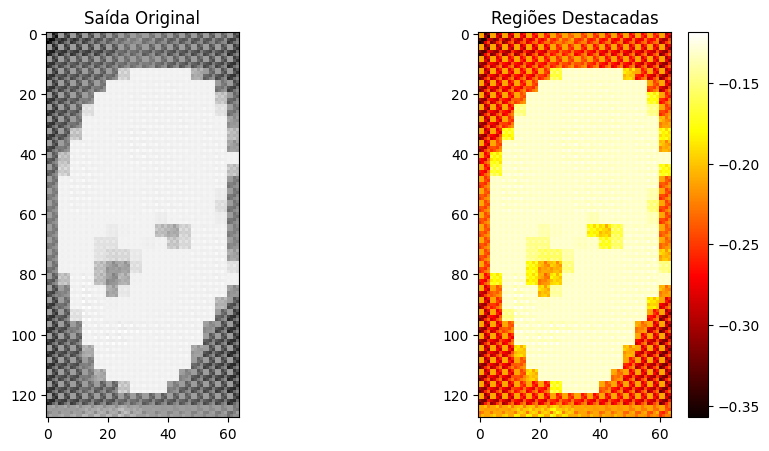

In [10]:
import numpy as np

# Realce das manchas na saída
output = sample_output.squeeze()[32, :, :]
highlighted = np.where(output < 0.9, output, 0)  # Destaca regiões com intensidade menor que 0.9

# Plot da imagem realçada
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Saída Original")
plt.imshow(output, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Regiões Destacadas")
plt.imshow(highlighted, cmap="hot")  # Usa um colormap para destacar
plt.colorbar()
plt.show()


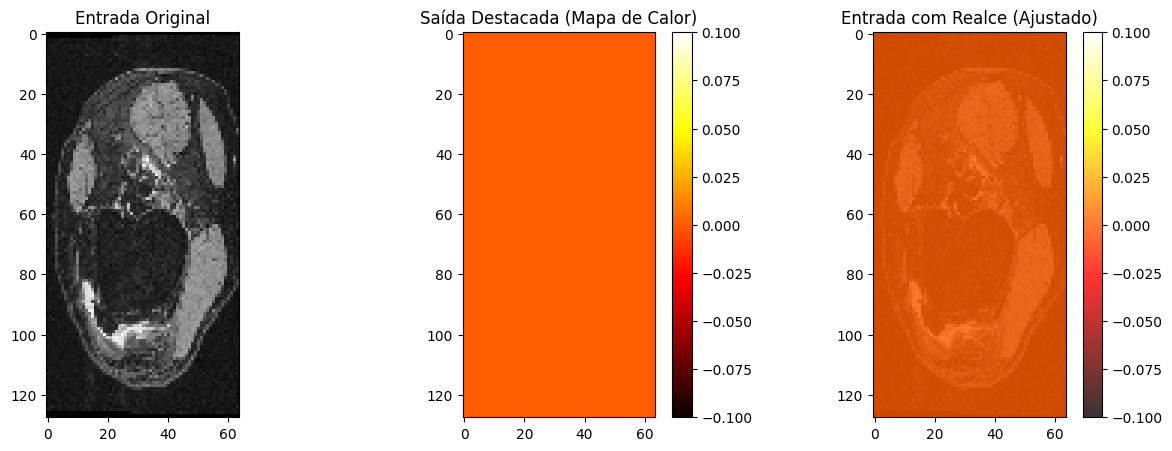

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Obtém a saída e a entrada
output = sample_output.squeeze()[32, :, :]  # Fatia da saída
input_image = sample_input.cpu().squeeze()[32, :, :]  # Fatia da entrada

# Cria uma máscara para valores ACIMA de um limiar
threshold = 0.3
mask = output > threshold  # Regiões que se destacam acima do limiar

# Normaliza a saída para destacar os valores em um mapa de calor
normalized_output = (output - output.min()) / (output.max() - output.min())

# Aplica o mapa de calor apenas nas áreas da máscara
highlighted_output = np.zeros_like(output)
highlighted_output[mask] = normalized_output[mask]  # Destacar apenas valores acima do limiar

# Plot das imagens
plt.figure(figsize=(15, 5))

# Entrada original
plt.subplot(1, 3, 1)
plt.title("Entrada Original")
plt.imshow(input_image, cmap="gray")

# Saída com máscara aplicada
plt.subplot(1, 3, 2)
plt.title("Saída Destacada (Mapa de Calor)")
plt.imshow(highlighted_output, cmap="hot")  # Aplica o mapa de calor
plt.colorbar()

# Sobreposição na entrada (ajustada para valores acima do limiar)
plt.subplot(1, 3, 3)
plt.title("Entrada com Realce (Ajustado)")
plt.imshow(input_image, cmap="gray")
plt.imshow(highlighted_output, cmap="hot", alpha=0.8)  # Sobrepõe com transparência
plt.colorbar()

plt.show()


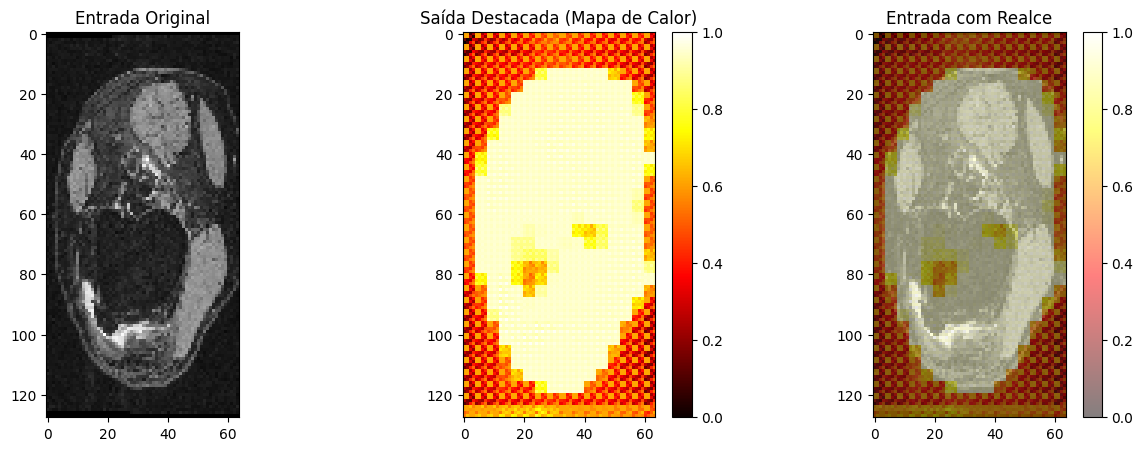

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Obtém a saída e a entrada
output = sample_output.squeeze()[32, :, :]  # Fatia da saída
input_image = sample_input.cpu().squeeze()[32, :, :]  # Fatia da entrada

# Cria uma máscara para valores abaixo de um limiar
threshold = 0.3
mask = output < threshold  # Regiões que se destacam

# Normaliza a saída para destacar os valores em um mapa de calor
normalized_output = (output - output.min()) / (output.max() - output.min())

# Aplica o mapa de calor apenas nas áreas da máscara
highlighted_output = np.zeros_like(output)
highlighted_output[mask] = normalized_output[mask]

# Plot das imagens
plt.figure(figsize=(15, 5))

# Entrada original
plt.subplot(1, 3, 1)
plt.title("Entrada Original")
plt.imshow(input_image, cmap="gray")

# Saída com máscara aplicada
plt.subplot(1, 3, 2)
plt.title("Saída Destacada (Mapa de Calor)")
plt.imshow(highlighted_output, cmap="hot")  # Aplica o mapa de calor
plt.colorbar()

# Sobreposição na entrada
plt.subplot(1, 3, 3)
plt.title("Entrada com Realce")
plt.imshow(input_image, cmap="gray")
plt.imshow(highlighted_output, cmap="hot", alpha=0.5)  # Sobrepõe com transparência
plt.colorbar()

plt.show()


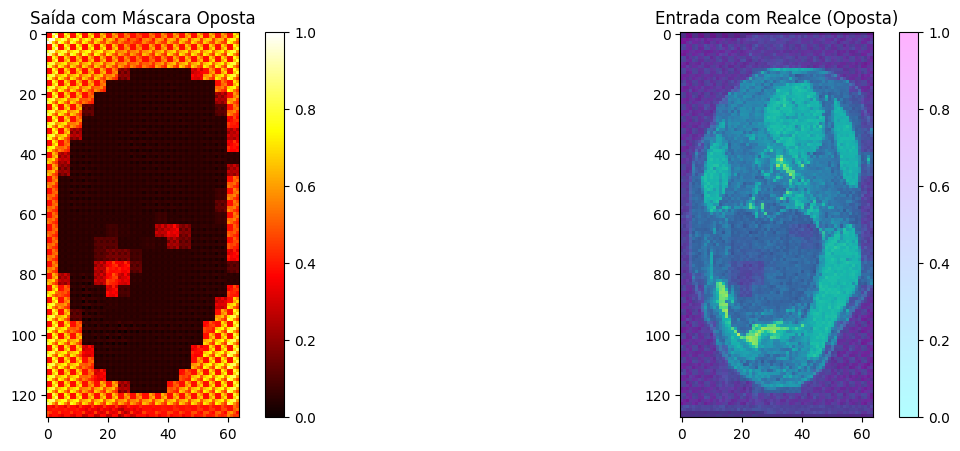

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Obtém a saída e a entrada
output = sample_output.squeeze()[32, :, :]  # Fatia da saída (uma "camada" específica)
input_image = sample_input.cpu().squeeze()[32, :, :]  # Fatia correspondente da entrada

# Parâmetros de ajuste para destacar valores
threshold_min = 0.5  # Mínimo da faixa para a máscara original
threshold_max = 1.0  # Máximo da faixa para a máscara original

# Máscara para valores na faixa (original) e fora da faixa (oposta)
mask = (output >= threshold_min) & (output <= threshold_max)  # Máscara original
inverse_mask = ~mask  # Máscara oposta (fora da faixa)

# Normaliza a saída para destacar os valores em um mapa de calor
normalized_output = (output - output.min()) / (output.max() - output.min())

# Mapa de calor para a máscara oposta
inverse_highlighted_output = np.zeros_like(output)
inverse_highlighted_output[inverse_mask] = 1 - normalized_output[inverse_mask]  # Inverte os valores para contraste

# Plot das imagens
plt.figure(figsize=(15, 5))

# Saída com máscara oposta
plt.subplot(1, 2, 1)
plt.title("Saída com Máscara Oposta")
plt.imshow(inverse_highlighted_output, cmap="hot")  # Aplica um mapa de calor invertido
plt.colorbar()

# Sobreposição com a máscara oposta
plt.subplot(1, 2, 2)
plt.title("Entrada com Realce (Oposta)")
plt.imshow(input_image, cmap="viridis")
plt.imshow(inverse_highlighted_output, cmap="cool", alpha=0.3)  # Sobrepõe com transparência
plt.colorbar()

plt.show()


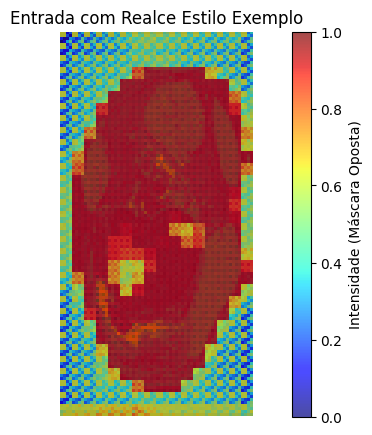

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Obtém a saída e a entrada
output = sample_output.squeeze()[32, :, :]  # Fatia da saída (uma "camada" específica)
input_image = sample_input.cpu().squeeze()[32, :, :]  # Fatia correspondente da entrada

# Parâmetros de ajuste para destacar valores
threshold_min = 0.5  # Mínimo da faixa para a máscara original
threshold_max = 1.0  # Máximo da faixa para a máscara original

# Máscara para valores na faixa (original) e fora da faixa (oposta)
mask = (output >= threshold_min) & (output <= threshold_max)  # Máscara original
inverse_mask = ~mask  # Máscara oposta (fora da faixa)

# Normaliza a saída para destacar os valores em um mapa de calor
normalized_output = (output - output.min()) / (output.max() - output.min())

# Mapa de calor para a máscara oposta
inverse_highlighted_output = np.zeros_like(output)
inverse_highlighted_output[inverse_mask] = normalized_output[inverse_mask]  # Mantém as áreas fora da faixa

# Plot da imagem final com sobreposição
plt.figure(figsize=(10, 5))

# Sobreposição com a máscara oposta (estilo da imagem exemplo)
plt.title("Entrada com Realce Estilo Exemplo")
plt.imshow(input_image, cmap="viridis")  # Base original em escala de cinza
plt.imshow(inverse_highlighted_output, cmap="jet", alpha=0.7)  # Sobrepõe com mapa de calor 'jet'
plt.axis("off")  # Remove os eixos para maior clareza visual
plt.colorbar(label="Intensidade (Máscara Oposta)")

plt.show()
